<a href="https://colab.research.google.com/github/SathyaSudha-96/TorchIO/blob/main/3D_UNet_TorchIO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TorchIO Installation**
---

In [1]:
!pip install --quiet --upgrade pip
!pip install --quiet unet==0.7.7
!pip install --quiet torchio==0.18.48
!apt -qq install tree

tree is already the newest version (1.7.0-5).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


**Loading required libraries**

---



In [2]:
import enum
import time
import random
import multiprocessing
from pathlib import Path

import torch
import torchvision
import torchio as tio
import torch.nn.functional as F
import torch.nn as nn

import numpy as np
from unet import UNet
from scipy import stats
import matplotlib.pyplot as plt

from IPython import display
from tqdm.notebook import tqdm
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Loading IXITiny Dataset using torchIO**

In [3]:
datasets = tio.datasets.IXITiny('content/drive/MyDrive/IXI_TorchIO/',download = True)

Root directory for IXITiny found: content/drive/MyDrive/IXI_TorchIO


In [4]:
print('Dataset size:', len(datasets), 'subjects')
print(datasets[0])
print(datasets[0].image)
print(datasets[0].label)

Dataset size: 566 subjects
Subject(Keys: ('image', 'label', 'subject_id'); images: 2)
ScalarImage(shape: (1, 83, 44, 55); spacing: (2.18, 4.13, 3.95); orientation: SRA+; memory: 392.3 KiB; dtype: torch.ShortTensor)
LabelMap(shape: (1, 83, 44, 55); spacing: (2.18, 4.13, 3.95); orientation: SRA+; memory: 196.2 KiB; dtype: torch.ByteTensor)


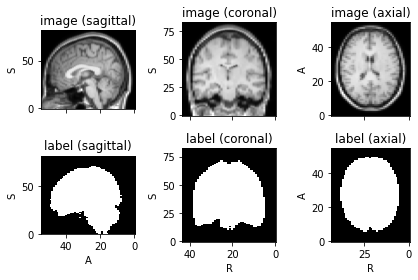

In [5]:
datasets[0].plot()

Functions for Degradation and Preprocessing

In [6]:
Noisy_transform = tio.Compose([
    tio.Resample(4),
    tio.CropOrPad((48, 60, 48)),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
    tio.RandomNoise(p = 0.2),
    tio.RandomMotion(p = 0.3),
    tio.RandomBlur(p = 0.5),
    tio.OneHot(),
])

transform = tio.Compose([
    tio.Resample(4),
    tio.CropOrPad((48, 60, 48)),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
    tio.OneHot(),
])
print(len(datasets))

566


In [7]:
Real_subjects, Noisy_subjects = torch.utils.data.random_split(datasets, (283, 283))

Real_set = tio.SubjectsDataset(
    Real_subjects, transform=transform)

Noisy_set = tio.SubjectsDataset(
   Noisy_subjects , transform=Noisy_transform)

print('Real set:', len(Real_set), 'subjects')
print('Noisy set:', len(Noisy_set), 'subjects')

Real set: 283 subjects
Noisy set: 283 subjects


In [8]:
Real_train , Real_test = torch.utils.data.random_split(Real_set,(192,91))
Noisy_train , Noisy_test = torch.utils.data.random_split(Noisy_set,(192,91))

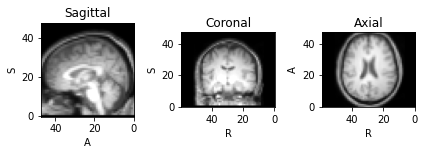

In [9]:
Real_set[3].image.plot()

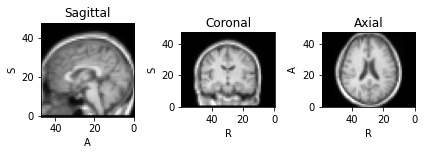

In [10]:
Noisy_set[3].image.plot()

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
def prepare_batch(x,y, device):
    inputs = x['image'][tio.DATA].to(device)
    targets = y['image'][tio.DATA].to(device)
    return inputs, targets

def get_model_and_optimizer(device):
    model = UNet(
        in_channels=1,
        out_classes=1,
        dimensions=3,
        num_encoding_blocks=3,
        out_channels_first_layer=8,
        normalization='batch',
        upsampling_type='linear',
        padding=True,
        activation='PReLU',
    ).to(device)
    optimizer = torch.optim.AdamW(model.parameters())
    return model, optimizer

**Dataloaders**

---



In [12]:
Noisy__train_loader = torch.utils.data.DataLoader(Noisy_train,batch_size=16,shuffle=False)
Real__train_loader = torch.utils.data.DataLoader(Real_train,batch_size=16,shuffle=False)
Noisy_test_loader = torch.utils.data.DataLoader(Noisy_test,batch_size=16,shuffle=False)
Real_test_loader = torch.utils.data.DataLoader(Real_test,batch_size=16,shuffle=False)

In [13]:
model, optimizer = get_model_and_optimizer(device)
loss = nn.MSELoss()
epochs = 10

In [18]:
for epoch in range(epochs):
  is_training = True
  epoch_losses = []
  times = []
  model.train(is_training)
  for batch_idx, (X,Y) in enumerate(zip(tqdm(Noisy__train_loader), Real__train_loader)):
    inputs, targets = prepare_batch(X,Y, device)
    #print('Input',inputs.shape)
    #print('Actual output',targets.shape)
    optimizer.zero_grad()
    with torch.set_grad_enabled(is_training):
      logits = model(inputs)
      #print('Predicted Output',logits.shape)
      probabilities = F.softmax(logits, dim=1)
      #print('probability',probabilities.shape)
      batch_losses = loss(logits, targets)
      batch_loss = batch_losses.mean()
      #print('Batch Loss Mean',batch_loss)
      if is_training:
        batch_loss.backward()
        optimizer.step()
        times.append(time.time())
        epoch_losses.append(batch_loss.item())
  epoch_losses = np.array(epoch_losses)
  print(f'mean loss: {epoch_losses.mean():0.3f}')

  0%|          | 0/6 [00:00<?, ?it/s]

mean loss: 4.130


  0%|          | 0/6 [00:00<?, ?it/s]

mean loss: 3.966


  0%|          | 0/6 [00:00<?, ?it/s]

mean loss: 3.801


  0%|          | 0/6 [00:00<?, ?it/s]

mean loss: 3.626


  0%|          | 0/6 [00:00<?, ?it/s]

mean loss: 3.452


**Save the Model**

---



In [19]:
#torch.save(model.state_dict(), '/content/drive/MyDrive/IXI_TorchIO/3dUNet.pth')

**Validation**

---



In [21]:
a = next(iter(Noisy_test_loader))
b = next(iter(Real_test_loader))
model.eval()
inputs, targets = prepare_batch(a,b, device)
with torch.no_grad():
    p = model(inputs)
    l = loss(p,targets)
    print('Validation Loss',l)

Validation Loss tensor(3.6155)


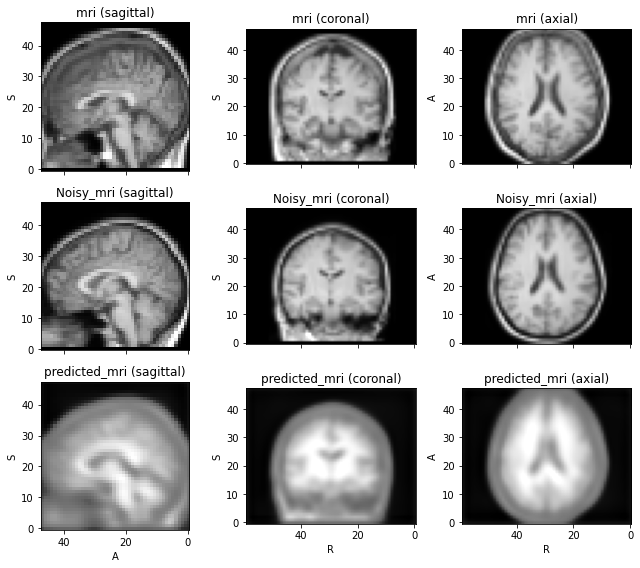

In [26]:
affine = a['image'][tio.AFFINE][0].numpy()
subject = tio.Subject(
    mri=tio.ScalarImage(tensor=b['image'][tio.DATA][2], affine=affine),
    Noisy_mri = tio.ScalarImage(tensor = a['image'][tio.DATA][2], affine=affine),
    predicted_mri=tio.ScalarImage(tensor=p[2], affine=affine),
)
subject.plot(figsize=(9, 8), cmap_dict={'predicted': 'gray'})